In [1]:
%matplotlib inline
import sys
sys.path.append("../lib/")
import os
import string
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.tree import plot_tree
import seaborn as sns
import graphviz
import shap

from raman_lib.visualization import (plot_spectra_peaks, 
                                     plot_qc_summary, 
                                     plot_confidence_scores, 
                                     plot_coefs, 
                                     plot_confusion_matrix, 
                                     plot_roc_curve, 
                                     plot_validation_curve,
                                     plot_roc_comparison,
                                     boxplot_comparison)

# Setup

In [2]:
dataset = "L_540_2022_C_E"

In [3]:
results_path = Path("../results/") / dataset
img_path = Path("../img/") / dataset

img_path.mkdir(parents=True, exist_ok=True)

In [4]:
data = pd.read_csv(results_path / (dataset + "_preprocessed.csv"))

y, y_key = pd.factorize(data.label)

In [5]:
rocs = {}
aucs = {}
p_vals = {}
accs = {}
f1_scores = {}
fit_times = {}
predict_times = {}

In [6]:
plt.style.use("seaborn-paper")
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 9

# Quality Control

In [7]:
qc_results = pd.read_csv(results_path / (dataset + "_qc_scores.csv"))

qc_results.describe()

,Median Height,N Peaks
count,644.000000,644.000000
mean,499.795421,11.905280
std,409.446582,7.186823
min,0.000000,0.000000
25%,251.732071,5.750000
50%,377.522729,13.000000
75%,622.191017,18.000000
max,3384.882316,27.000000


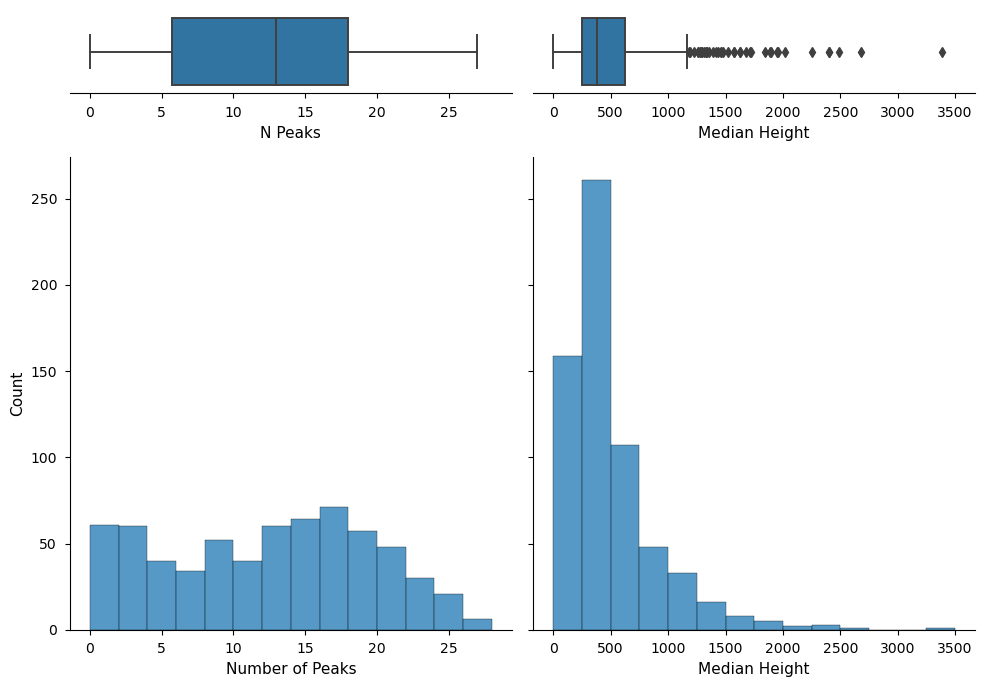

In [8]:
fig, ((ax_box1, ax_box2), (ax_hist1, ax_hist2)) = plt.subplots(
    2, 2, sharex="col", sharey="row", gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=qc_results.iloc[:,1], ax=ax_box1)
sns.boxplot(x=qc_results.iloc[:,0], ax=ax_box2)
sns.histplot(qc_results.iloc[:,1], ax=ax_hist1, binrange=None, binwidth=2)
sns.histplot(qc_results.iloc[:,0], ax=ax_hist2, binrange=None, binwidth=250)

ax_box1.set(yticks=[])
ax_box2.set(yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box1, left=True)
sns.despine(ax=ax_box2, left=True)

ax_hist1.set_xlabel("Number of Peaks")
ax_hist2.set_xlabel(qc_results.columns[0])

#ax_hist1.set_ylim([None, ymax_peaks])
#ax_hist2.set_ylim([None, ymax_score])

ax_box1.tick_params(axis="x", labelbottom=True)
ax_box2.tick_params(axis="x", labelbottom=True)

fig.tight_layout()

# Dimensionality Reduction
## LDA

In [9]:
current_path = results_path / "lda_dim_reduction/lda/"
name = "LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,1.000000,0.732783,0.999708,0.682667,0.999708,0.688352,0.431106,0.004809,6.088197e-09
std,0.000001,0.011817,0.000408,0.012036,0.000408,0.014791,0.029528,0.001650,1.602079e-08
min,0.999997,0.706222,0.998750,0.663333,0.998749,0.660353,0.381089,0.003217,2.829740e-12
25%,1.000000,0.725472,0.999479,0.677500,0.999479,0.678192,0.411980,0.003803,3.365343e-10
50%,1.000000,0.733778,1.000000,0.680000,1.000000,0.688791,0.420401,0.004039,1.018173e-09
75%,1.000000,0.739722,1.000000,0.688750,1.000000,0.698518,0.446635,0.005211,3.070974e-09
max,1.000000,0.753111,1.000000,0.706667,1.000000,0.716390,0.497931,0.008925,7.181610e-08


In [10]:
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

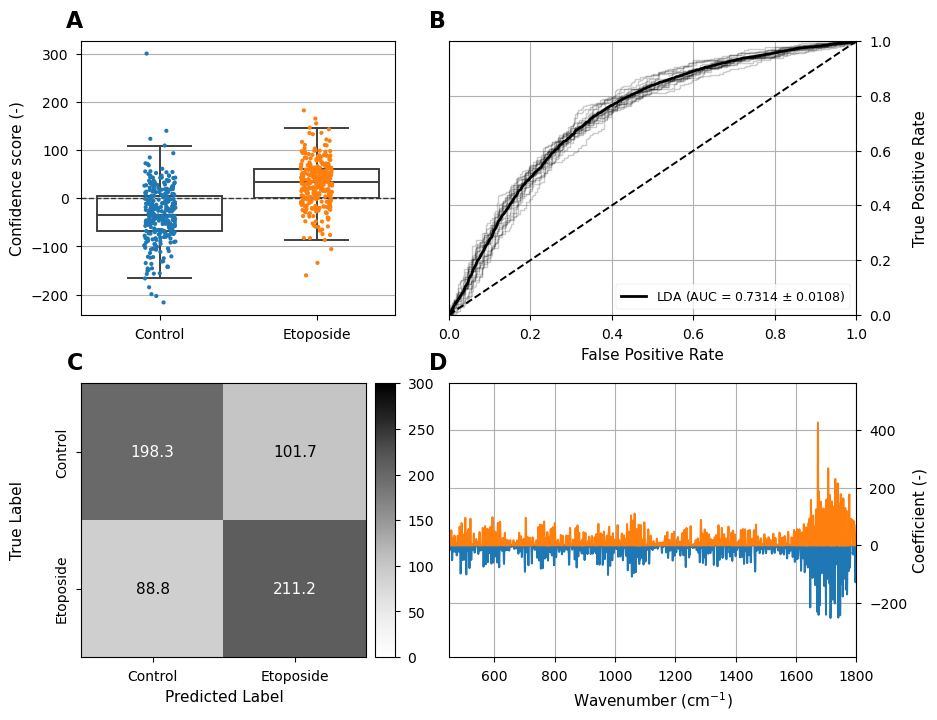

In [52]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8),
                        gridspec_kw={"width_ratios": (1, 1.3)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax2)
ax2.set_xlabel(f"False Positive Rate")
ax2.set_ylabel(f"True Positive Rate")
ax2.legend(loc="lower right")
ax2.grid()
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")

ax4 = axs[1,1]
plot_coefs(coef_df, ax=ax4)
ax4.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax4.set_ylabel("Coefficient (-)")
ax4.margins(x=0, y=0.2)
ax4.grid()
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.15, hspace=0.25)
fig.align_labels()

fig.savefig(img_path / "lda_combined.png", format="png", dpi=300, bbox_inches="tight")

## PCA-LDA

In [12]:
current_path = results_path / "lda_dim_reduction/pca_lda/"
name = "PCA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.802884,0.621225,0.732188,0.591750,0.730405,0.584489,2.691102,0.002716,0.111143
std,0.031092,0.021062,0.025527,0.023072,0.025234,0.028335,0.196450,0.000911,0.108404
min,0.732938,0.577000,0.676250,0.545000,0.673243,0.524276,2.497253,0.001118,0.009149
25%,0.784445,0.610250,0.721250,0.575000,0.720652,0.568618,2.522008,0.002073,0.033944
50%,0.804000,0.619250,0.733125,0.592500,0.730514,0.588095,2.619280,0.002508,0.078186
75%,0.828148,0.632875,0.750312,0.610000,0.746768,0.609554,2.814586,0.003388,0.152129
max,0.859062,0.666000,0.776250,0.630000,0.771610,0.624212,3.145108,0.004114,0.421380


In [13]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

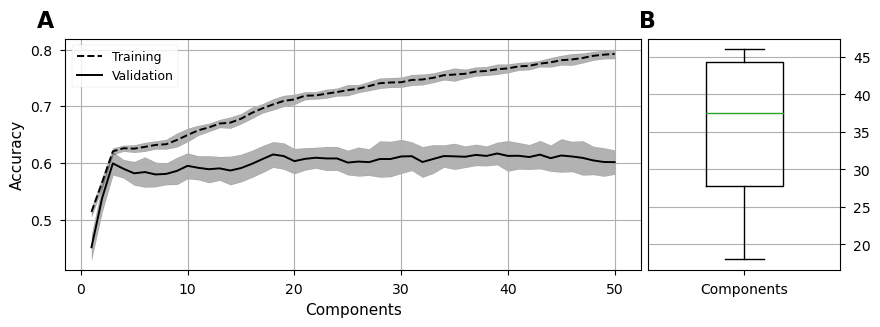

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Components"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "pcalda_validation.png", format="png", dpi=300, bbox_inches="tight")

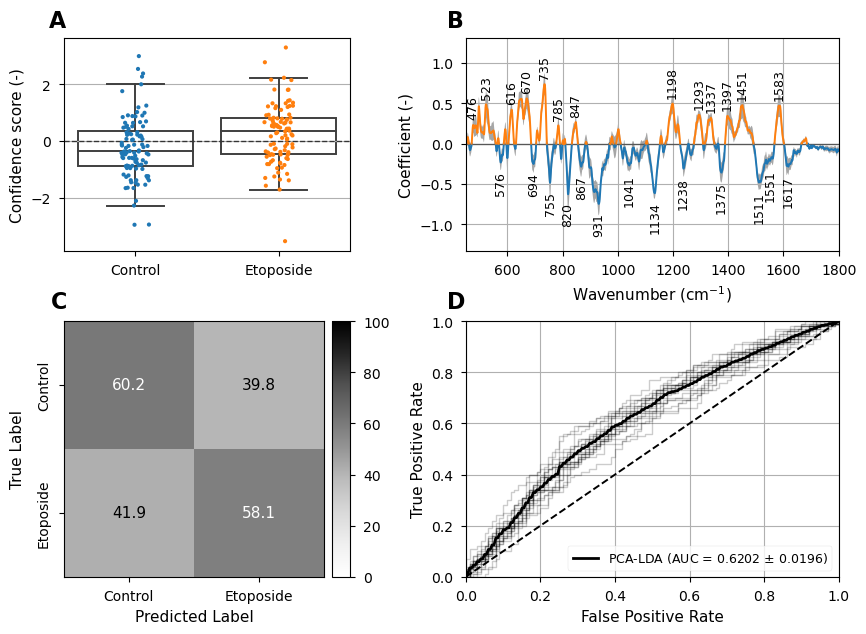

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.2, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "pcalda_combined.png", format="png", dpi=300, bbox_inches="tight")

## NMF-LDA

In [16]:
current_path = results_path / "lda_dim_reduction/nmf_lda/"
name = "NMF-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.803547,0.627475,0.730125,0.600000,0.727934,0.590428,3.617639,0.020509,0.078978
std,0.020402,0.029500,0.017419,0.022183,0.017824,0.022373,0.373533,0.020064,0.079836
min,0.769406,0.576500,0.707500,0.560000,0.702018,0.541389,3.265239,0.008290,0.007016
25%,0.787352,0.607750,0.715625,0.585000,0.711925,0.579327,3.379619,0.011632,0.020544
50%,0.804094,0.632250,0.727500,0.597500,0.727712,0.589235,3.524452,0.012823,0.059701
75%,0.815383,0.648375,0.743437,0.616250,0.740326,0.605664,3.706415,0.017174,0.107822
max,0.849250,0.671500,0.762500,0.635000,0.759517,0.629597,4.882404,0.093630,0.276082


In [17]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

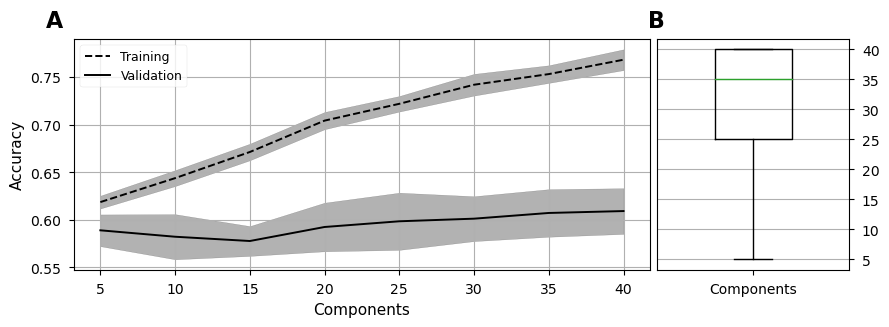

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Components")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Components"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "nmflda_validation.png", format="png", dpi=300, bbox_inches="tight")

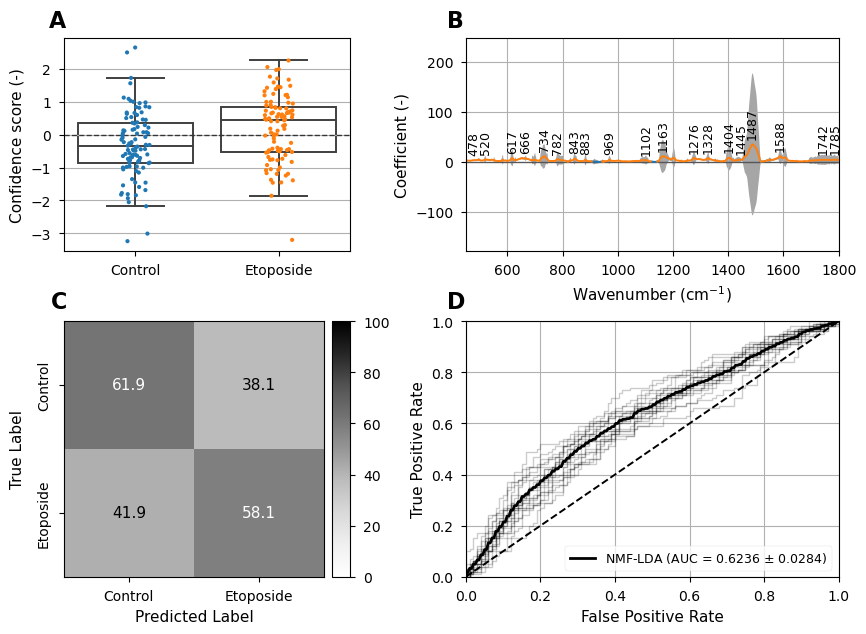

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 2.5, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "nmflda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Feature Agglomeration (FA) - LDA

In [20]:
current_path = results_path / "lda_dim_reduction/fa_lda/"
name = "FA-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.791998,0.660400,0.717812,0.610750,0.719437,0.607625,2.848447,0.002321,0.063938
std,0.017042,0.018636,0.013854,0.027255,0.013734,0.026461,0.258089,0.000361,0.094386
min,0.753594,0.623000,0.688750,0.545000,0.692422,0.540404,2.647138,0.001871,0.000504
25%,0.779523,0.646500,0.709688,0.593750,0.710302,0.595315,2.742624,0.002130,0.014440
50%,0.797094,0.660750,0.718125,0.615000,0.719275,0.608972,2.772859,0.002192,0.031379
75%,0.802695,0.672625,0.724375,0.626250,0.726128,0.621995,2.886401,0.002464,0.077245
max,0.820375,0.692000,0.747500,0.670000,0.749019,0.651543,3.876591,0.003153,0.421380


In [21]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

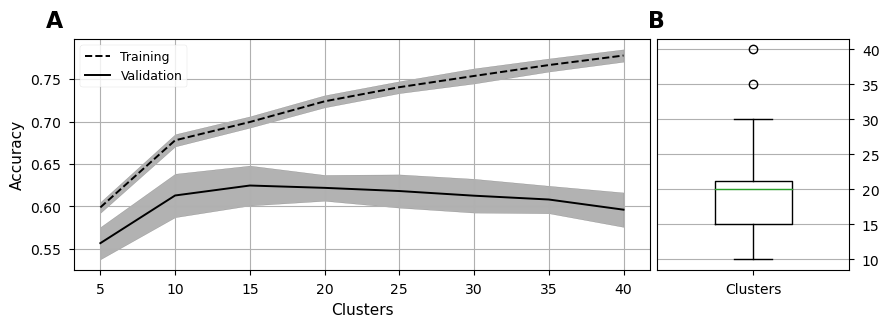

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Clusters")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Clusters"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "falda_validation.png", format="png", dpi=300, bbox_inches="tight")

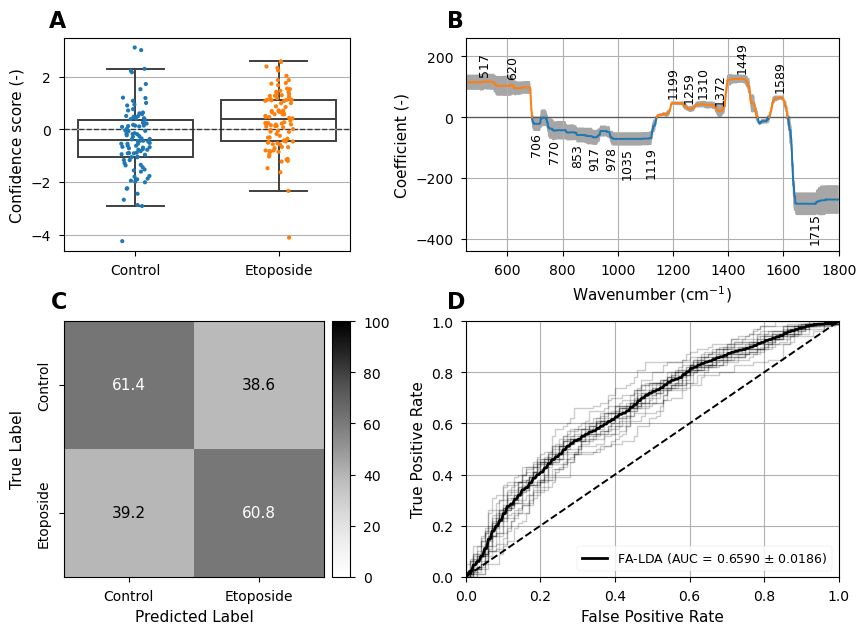

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 20, 
                                                                      "min_dist": 100,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "falda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Peak-LDA

In [24]:
current_path = results_path / "lda_dim_reduction/peak_lda/"
name = "Peak-LDA"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.777066,0.582075,0.708563,0.562500,0.709320,0.545550,0.396468,0.002752,0.284205
std,0.024224,0.023780,0.020736,0.023592,0.021771,0.029378,0.066017,0.000848,0.187401
min,0.743344,0.538000,0.681250,0.525000,0.682223,0.488641,0.329930,0.001847,0.037589
25%,0.759516,0.567000,0.690937,0.545000,0.693273,0.523922,0.356680,0.002206,0.123729
50%,0.769734,0.578500,0.706250,0.555000,0.702256,0.541429,0.371786,0.002542,0.275359
75%,0.791148,0.596250,0.721250,0.580000,0.720236,0.569550,0.402314,0.002960,0.406604
max,0.818000,0.644500,0.755000,0.610000,0.761819,0.609386,0.572676,0.005348,0.681519


In [25]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

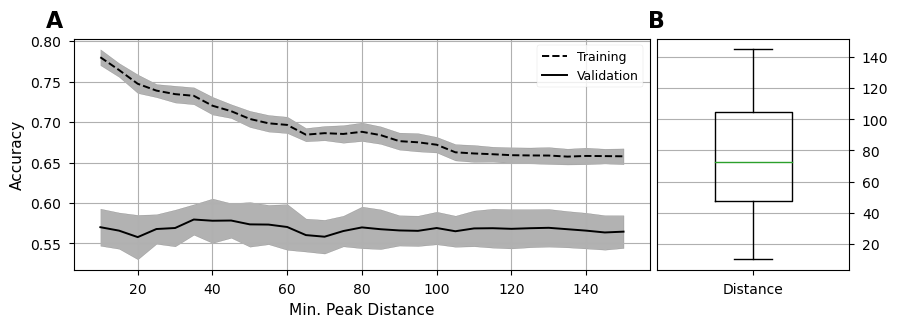

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xlabel("Min. Peak Distance")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Distance"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "peaklda_validation.png", format="png", dpi=300, bbox_inches="tight")

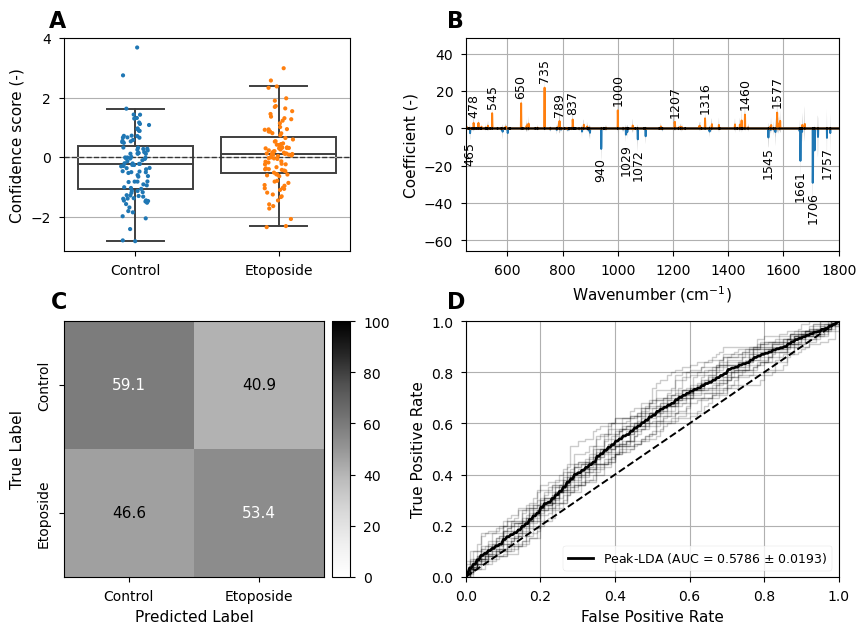

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 2.5, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.25)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "peaklda_combined.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of LDA with different dimensionality Reductions

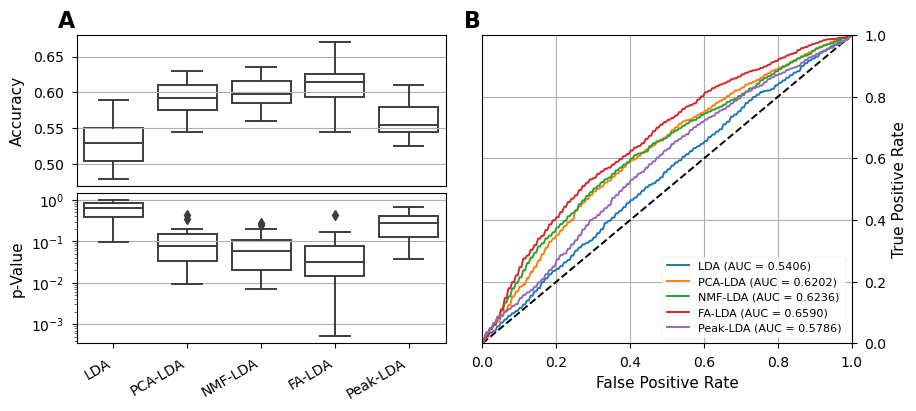

In [28]:
fig = plt.figure(figsize=(10,4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="LDA", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="LDA", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="LDA")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")
    
fig.align_ylabels()

fig.savefig(img_path / "lda_comparison.png", format="png", dpi=300, bbox_inches="tight")

# Regularized Models
## Logistic Regression (l1)

In [29]:
current_path = results_path / "regularized_models/logreg_l1/"
name = "Log. Reg. (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.941941,0.607175,0.888625,0.577250,0.890771,0.571470,0.867271,0.010985,0.207873
std,0.023365,0.028376,0.034261,0.030757,0.032972,0.036219,0.057482,0.005103,0.185830
min,0.896375,0.547000,0.808750,0.515000,0.815926,0.504899,0.792685,0.003947,0.003117
25%,0.928625,0.591000,0.868750,0.563750,0.871184,0.555217,0.836524,0.008335,0.083239
50%,0.942438,0.606750,0.888125,0.570000,0.889145,0.566812,0.850551,0.009674,0.193601
75%,0.958953,0.622750,0.916875,0.588750,0.919697,0.594347,0.879420,0.013679,0.254698
max,0.977781,0.659000,0.946250,0.655000,0.945063,0.660782,1.048393,0.025447,0.843776


In [30]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

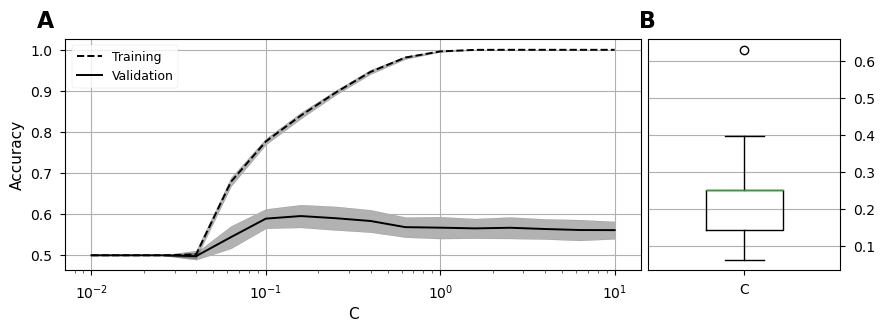

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "logreg_l1_validation.png", format="png", dpi=300, bbox_inches="tight")

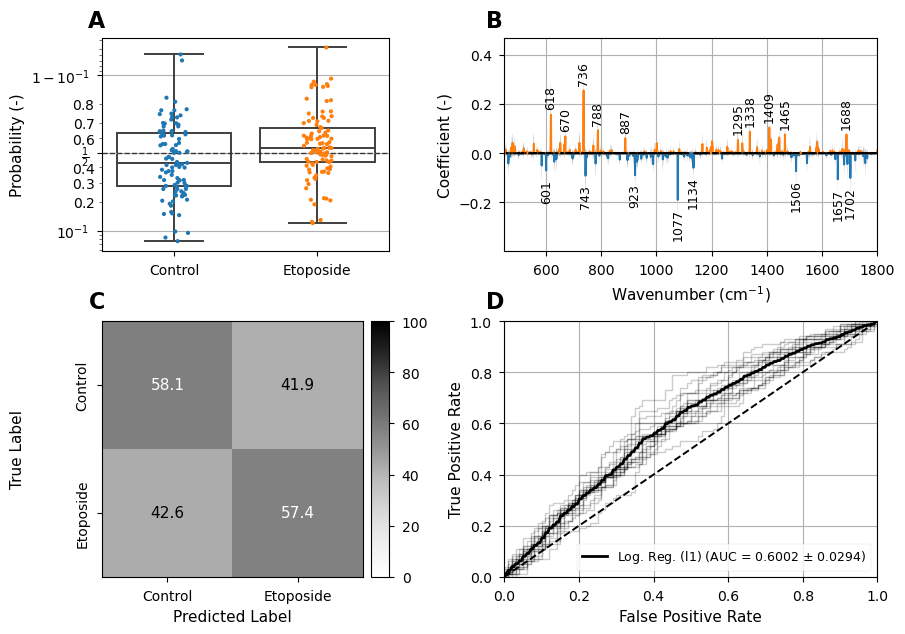

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.15)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "logreg_l1_combined.png", format="png", dpi=300, bbox_inches="tight")

## Logistic Regression (l2)

In [33]:
current_path = results_path / "regularized_models/logreg_l2/"
name = "Log. Reg. (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.902894,0.633525,0.836375,0.591000,0.834075,0.573401,0.868885,0.009097,0.107809
std,0.014855,0.021562,0.020273,0.022396,0.021949,0.023564,0.079354,0.003757,0.101705
min,0.864375,0.598000,0.783750,0.545000,0.774691,0.503404,0.801241,0.003793,0.012822
25%,0.895422,0.616000,0.828438,0.573750,0.824932,0.565584,0.825529,0.006654,0.026142
50%,0.904000,0.634750,0.837500,0.592500,0.834774,0.576753,0.836543,0.008694,0.072941
75%,0.910789,0.650125,0.849063,0.610000,0.845970,0.586476,0.876343,0.010479,0.163386
max,0.927344,0.673000,0.865000,0.625000,0.863791,0.604575,1.098684,0.018214,0.385547


In [34]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

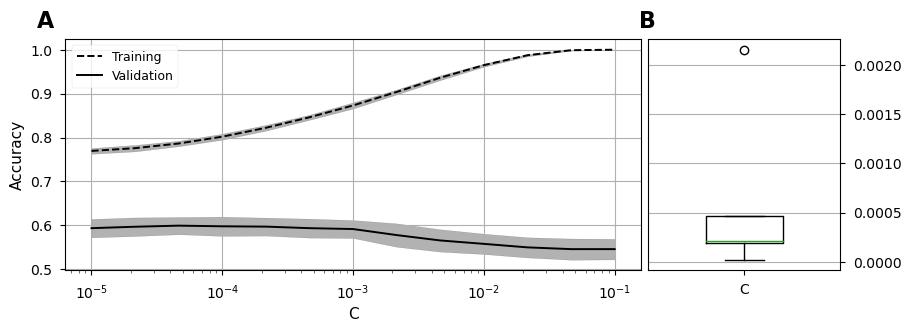

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "logreg_l2_validation.png", format="png", dpi=300, bbox_inches="tight")

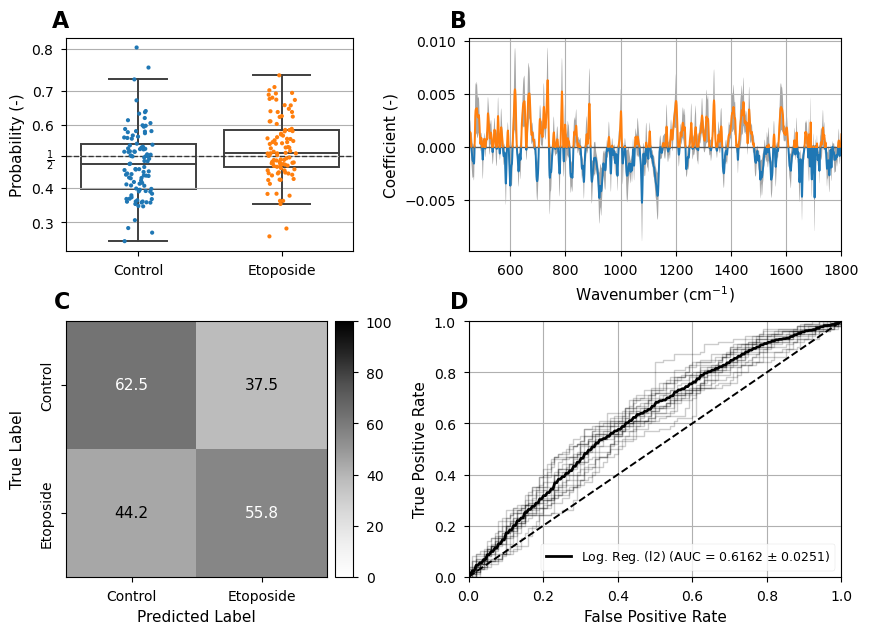

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.05)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "logreg_l2_combined.png", format="png", dpi=300, bbox_inches="tight")

## Support Vector Machine (l1)

In [37]:
current_path = results_path / "regularized_models/svm_l1/"
name = "SVM (l1)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.941312,0.611150,0.885938,0.583000,0.887812,0.580766,1.736878,0.013598,0.156276
std,0.021225,0.027589,0.030000,0.023974,0.028752,0.029647,0.126823,0.011201,0.118455
min,0.895281,0.551000,0.810000,0.545000,0.816405,0.523779,1.579700,0.005445,0.008973
25%,0.929344,0.595250,0.874375,0.567500,0.876011,0.562993,1.655363,0.006966,0.076282
50%,0.941828,0.613000,0.886875,0.587500,0.888369,0.578410,1.697803,0.011060,0.109973
75%,0.957047,0.629250,0.903438,0.595000,0.904574,0.602778,1.792957,0.014542,0.213920
max,0.977281,0.659500,0.948750,0.635000,0.947629,0.629346,2.091296,0.054631,0.430543


In [38]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

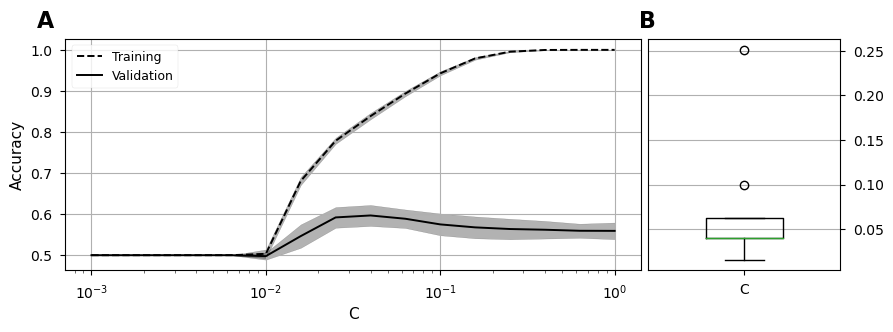

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "svm_l1_validation.png", format="png", dpi=300, bbox_inches="tight")

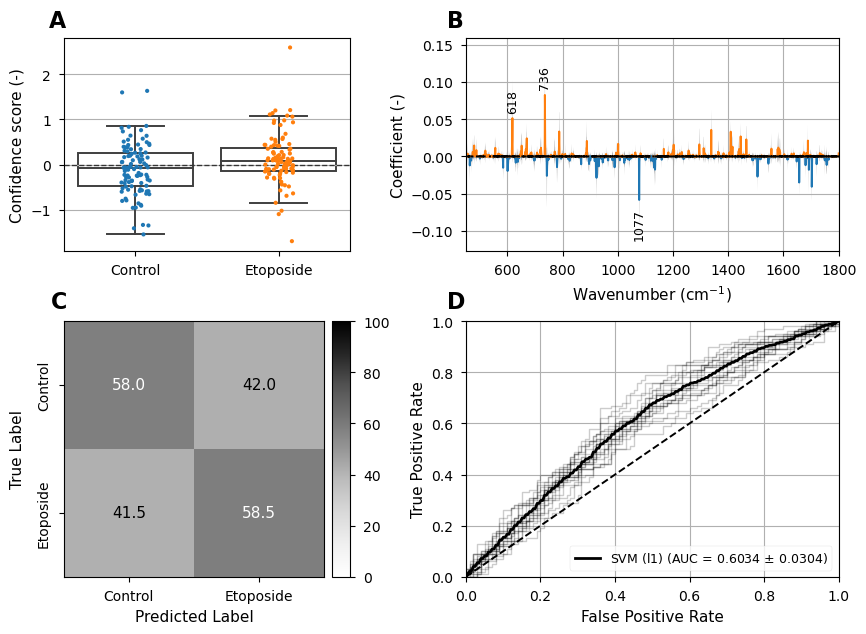

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True, annotate=True, annot_kw={"min_height": 0.05, 
                                                                      "min_dist": 80,
                                                                      "offset": 6,
                                                                      "fontsize": 9})
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.15)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "svm_l1_combined.png", format="png", dpi=300, bbox_inches="tight")

## Support Vector Machine (l2)

In [41]:
current_path = results_path / "regularized_models/svm_l2/"
name = "SVM (l2)"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.907292,0.632975,0.842000,0.588000,0.840530,0.571577,0.905831,0.010642,0.133089
std,0.011727,0.024233,0.018211,0.026178,0.019026,0.027993,0.068070,0.004134,0.136236
min,0.884531,0.592500,0.803750,0.535000,0.800534,0.492650,0.801524,0.003452,0.007641
25%,0.901555,0.612000,0.830000,0.568750,0.829795,0.561206,0.871092,0.007780,0.029876
50%,0.908047,0.634250,0.840625,0.590000,0.839323,0.573317,0.886528,0.009876,0.083114
75%,0.913109,0.649125,0.856250,0.610000,0.855609,0.588783,0.920269,0.013483,0.195379
max,0.932500,0.673500,0.876250,0.635000,0.875948,0.624413,1.063440,0.021174,0.515181


In [42]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
conf_score_df = pd.read_csv(current_path / "confidence_scores.csv", header=None)
coef_df = pd.read_csv(current_path / "coefficients.csv")
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

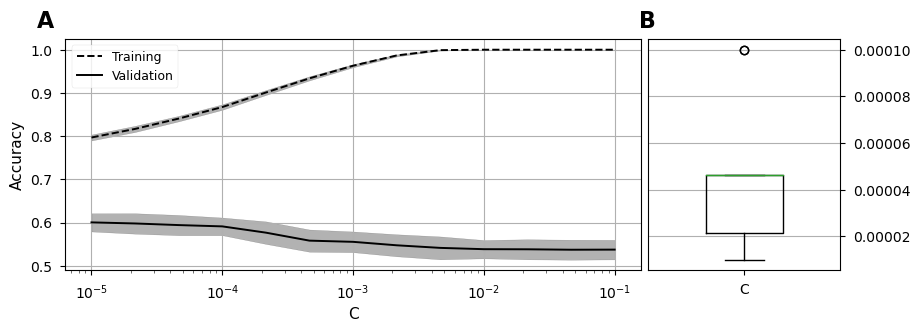

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["C"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "svm_l2_validation.png", format="png", dpi=300, bbox_inches="tight")

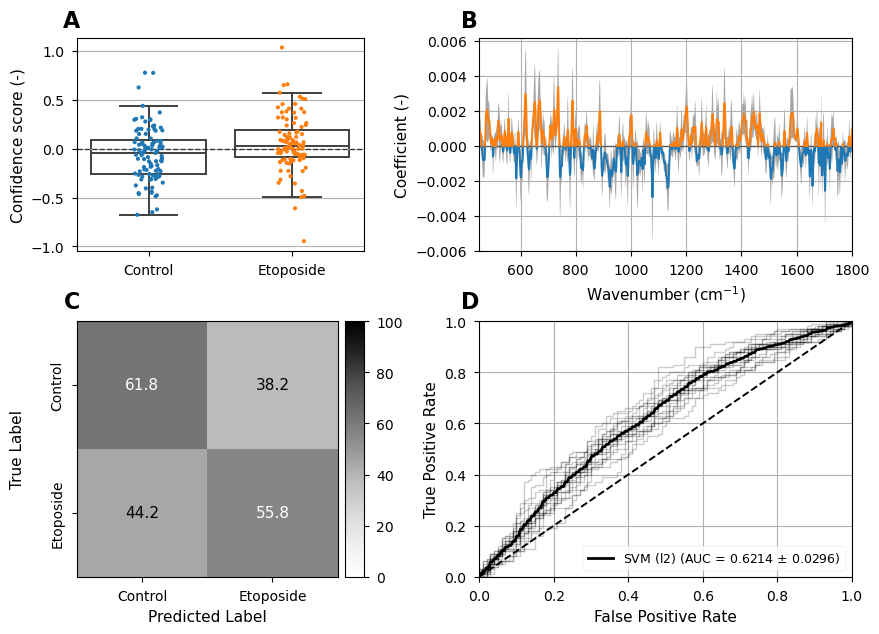

In [44]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(conf_score_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_ylabel("Confidence score (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(coef_df, ax=ax2, show_range=True)
ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Coefficient (-)")
ax2.margins(x=0, y=0.05)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(conf_score_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "svm_l2_combined.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of Regularized Models (Logistic Regression and Linear SVM)

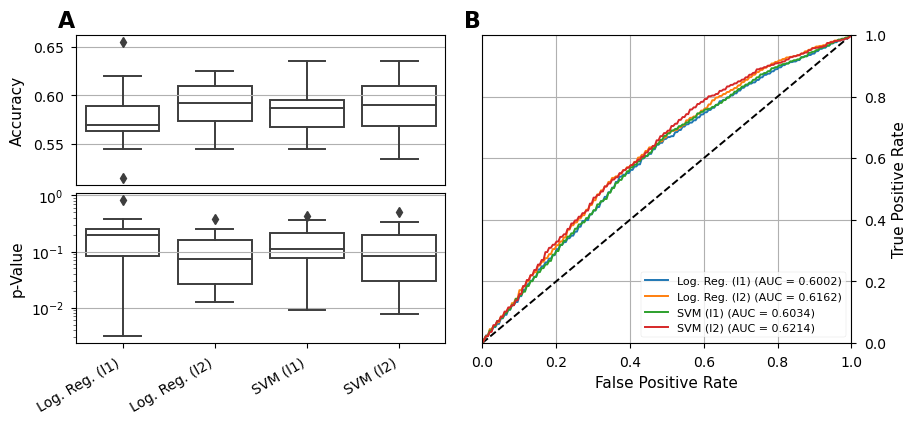

In [45]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="Log. Reg.|SVM", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="Log. Reg.|SVM", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="Log. Reg.|SVM")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")
    
fig.align_ylabels()

fig.savefig(img_path / "linear_comparison.png", format="png", dpi=300, bbox_inches="tight")

# Tree-based Models
## Decision Tree

In [46]:
current_path = results_path / "tree_based_models/decision_tree/"
name = "Decision Tree"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.817609,0.532238,0.805875,0.530500,0.754632,0.482173,1.373140,0.002021,0.597222
std,0.072817,0.035457,0.069965,0.032963,0.125294,0.088936,0.071715,0.000330,0.335512
min,0.666016,0.474500,0.657500,0.485000,0.467468,0.296486,1.281804,0.001503,0.151113
25%,0.788988,0.502563,0.779687,0.500000,0.704174,0.430841,1.329643,0.001692,0.283225
50%,0.811031,0.526250,0.797500,0.522500,0.743984,0.468691,1.356314,0.002036,0.727140
75%,0.856250,0.558125,0.846562,0.561250,0.855239,0.563532,1.403747,0.002290,0.913369
max,0.967219,0.590500,0.938750,0.585000,0.940331,0.632769,1.533255,0.002525,1.000000


In [47]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

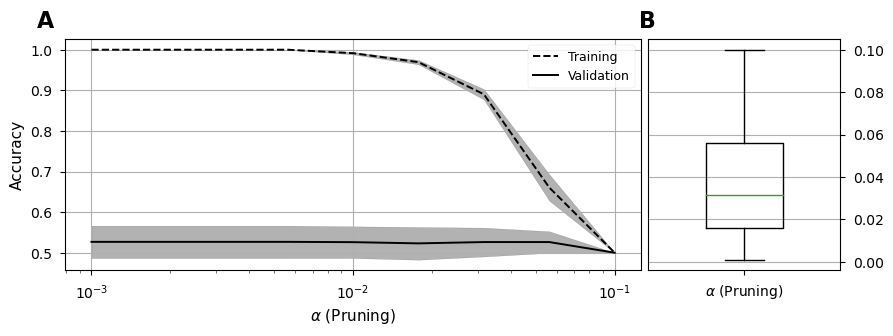

In [48]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)

ax1.set_xscale("log")
ax1.set_xlabel(r"$\alpha$ (Pruning)")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels([r"$\alpha$ (Pruning)"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "tree_validation.png", format="png", dpi=300, bbox_inches="tight")

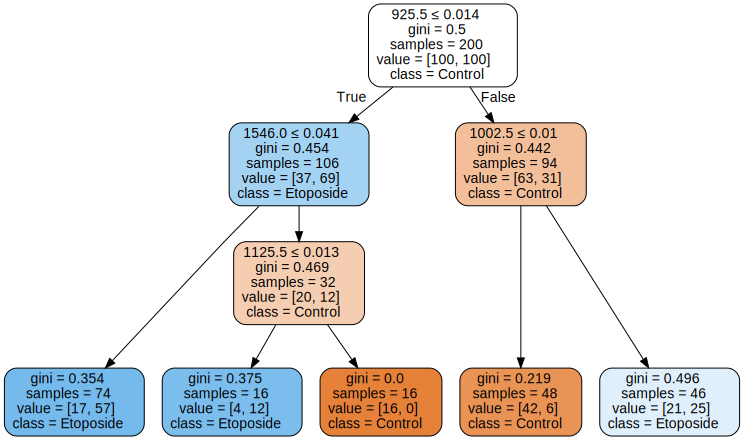

In [49]:
tree = graphviz.Source.from_file(current_path / "tree.dot")
tree.render(img_path / "tree", format="png")
tree

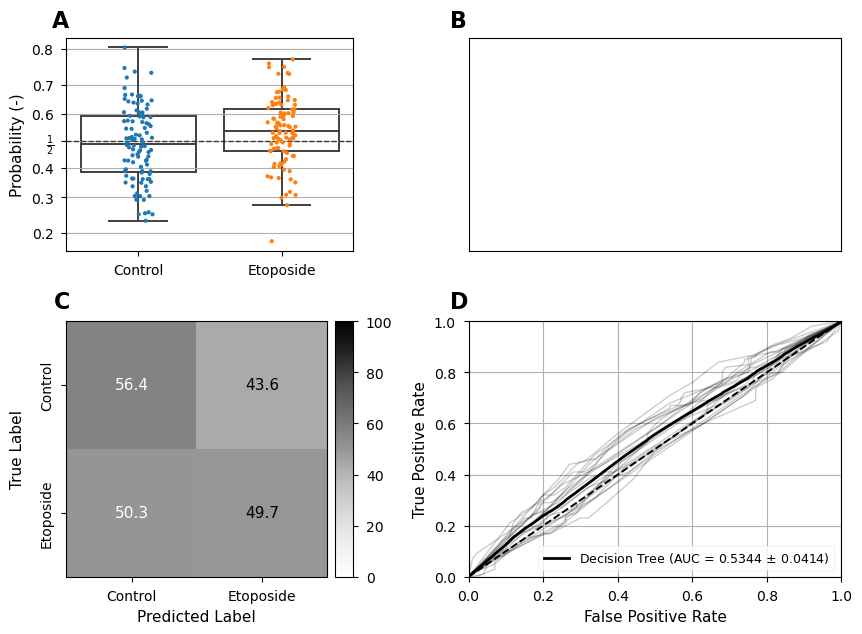

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "tree_combined.png", format="png", dpi=300, bbox_inches="tight")

## Random Forest

In [7]:
current_path = results_path / "tree_based_models/random_forest/"
name = "Random Forest"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,0.987066,0.955278,0.937688,0.891917,0.935655,0.887066,1.629738,0.004708,1.466243e-43
std,0.000367,0.001894,0.002644,0.005522,0.002788,0.005863,0.178953,0.000247,4.509599e-43
min,0.986493,0.951500,0.932083,0.881667,0.929534,0.877480,1.446440,0.004327,2.961413e-47
25%,0.986801,0.953750,0.936250,0.888333,0.934069,0.882722,1.509028,0.004510,3.108108e-46
50%,0.987097,0.955472,0.937708,0.892500,0.935647,0.887413,1.552358,0.004644,2.912804e-45
75%,0.987365,0.955944,0.939167,0.896667,0.937186,0.891986,1.748614,0.004896,5.414313e-44
max,0.987566,0.959333,0.944167,0.900000,0.942484,0.896426,2.059507,0.005325,2.018704e-42


In [26]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

### XAI - shap
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)
shap_val_df = pd.DataFrame(data=np.absolute(shap_vals), columns=shap_features)

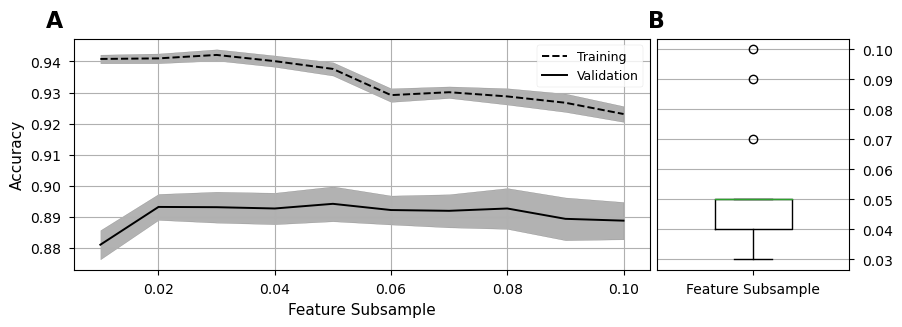

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)
ax1.set_xlabel("Feature Subsample")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Feature Subsample"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "forest_validation.png", format="png", dpi=300, bbox_inches="tight")

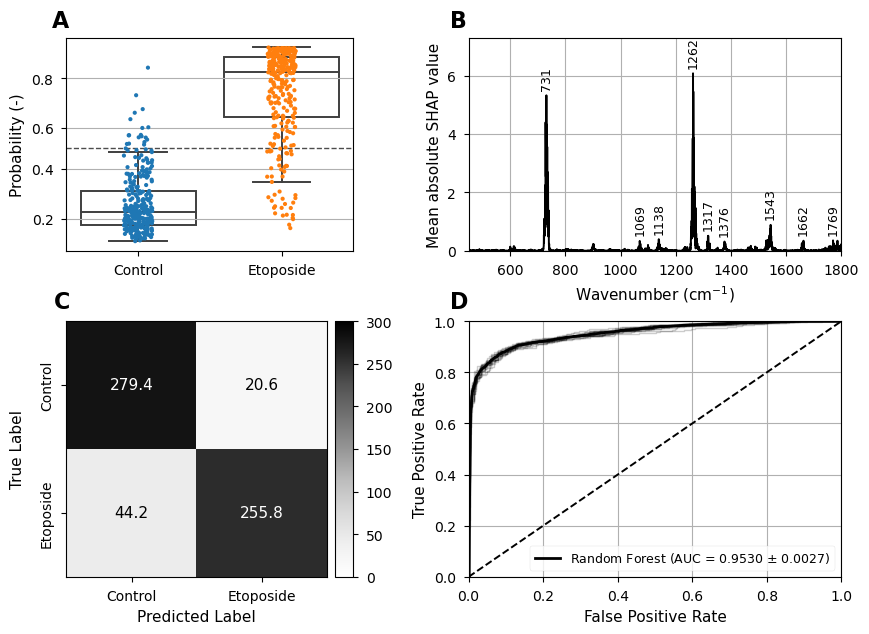

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(shap_val_df, ax=ax2, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})

ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Mean absolute SHAP value")
ax2.margins(x=0, y=0.2)
ax2.set_ylim(0, None)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "forest_combined.png", format="png", dpi=300, bbox_inches="tight")

### Explainable AI - SHAP

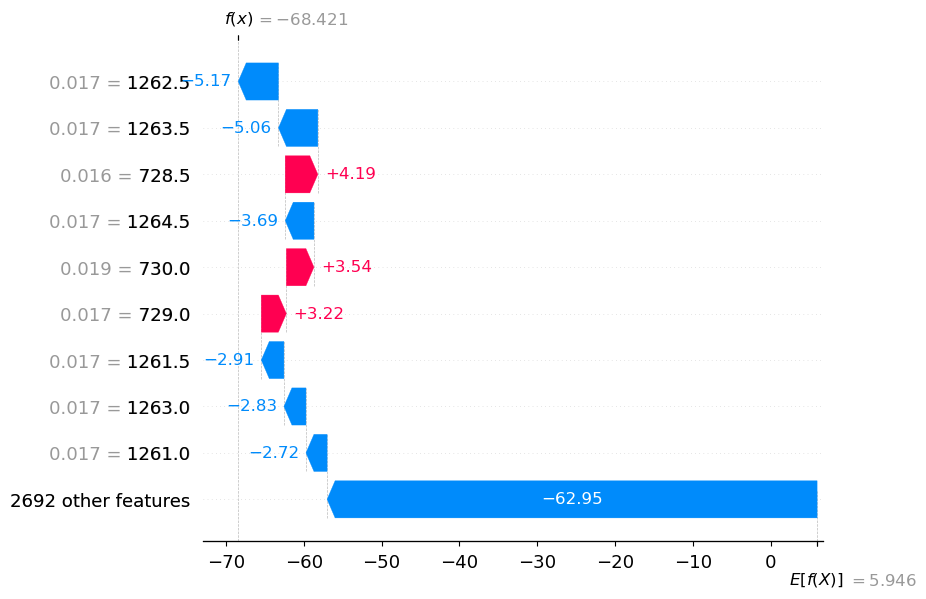

In [17]:
fig, ax = plt.subplots()
first_expl = explanation[5]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "forest_shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")

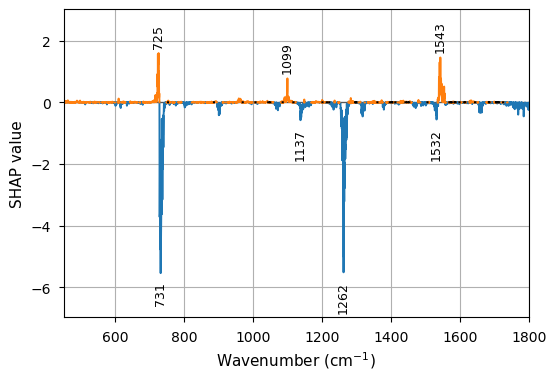

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
plot_coefs(pd.Series(shap_vals[1,:], index=shap_features), ax=ax, annotate=True, annot_kw={"min_height": 0.5, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})
ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("SHAP value")
ax.margins(x=0, y=0.2)
ax.grid()

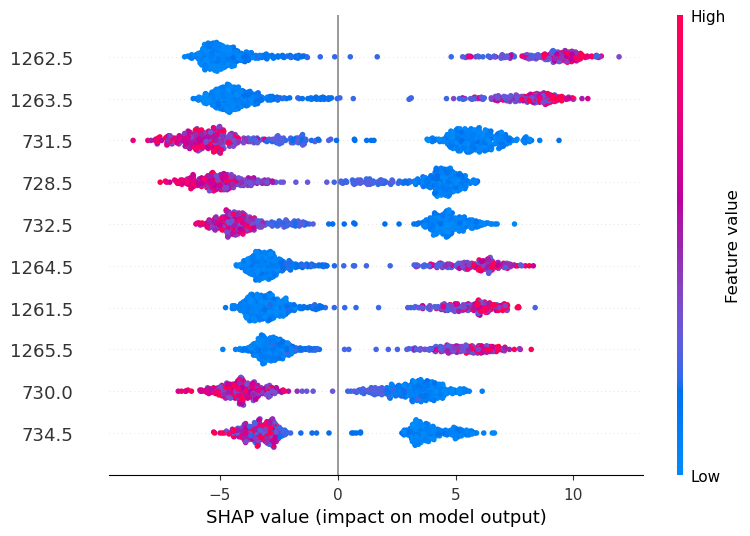

In [51]:
fig, ax = plt.subplots()
shap.summary_plot(explanation, feature_names=shap_features, max_display=10)

fig.savefig(img_path / "forest_shap.png", format="png", dpi=300, bbox_inches="tight")

## Gradient Boosted Trees

In [52]:
current_path = results_path / "tree_based_models/gbdt/"
name = "Gradient-boost"

ct_df = pd.read_csv(current_path / "ct_results.csv")

accs[name] = ct_df.test_accuracy
f1_scores[name] = ct_df.test_f1
fit_times[name] = ct_df.fit_time
predict_times[name] = ct_df.predict_time
p_vals[name] = ct_df.p_value

ct_df.describe()

,train_roc_auc,test_roc_auc,train_accuracy,test_accuracy,train_f1,test_f1,fit_time,predict_time,p_value
count,20.0,20.000000,20.0,20.000000,20.0,20.000000,20.000000,20.000000,2.000000e+01
mean,1.0,0.966308,1.0,0.904917,1.0,0.902147,1.909658,0.005345,3.251218e-44
std,0.0,0.004025,0.0,0.008794,0.0,0.009570,0.304136,0.003011,1.108934e-43
min,1.0,0.958056,1.0,0.886667,1.0,0.881199,1.743854,0.004315,1.286635e-49
25%,1.0,0.965194,1.0,0.900833,1.0,0.897444,1.762522,0.004535,6.280064e-48
50%,1.0,0.965806,1.0,0.905000,1.0,0.902715,1.792711,0.004611,8.542389e-47
75%,1.0,0.969236,1.0,0.911667,1.0,0.909976,1.882947,0.004697,1.337773e-45
max,1.0,0.972444,1.0,0.918333,1.0,0.916538,2.998547,0.018073,4.931206e-43


In [53]:
cv_df = pd.read_csv(current_path / "cv_results.csv")
param_df = pd.read_csv(current_path / "param_results.csv")
proba_df = pd.read_csv(current_path / "probabilities.csv", header=None)
pred_df = pd.read_csv(current_path / "predictions.csv", header=None)

### XAI - shap
shap_base_vals = np.genfromtxt(current_path / "shap/base_values.csv")
shap_vals = np.genfromtxt(current_path / "shap/values.csv", delimiter=",")
shap_data = np.genfromtxt(current_path / "shap/data.csv", delimiter=",")
shap_features = np.genfromtxt(current_path / "shap/feature_names.csv")
explanation = shap.Explanation(values=shap_vals, base_values=shap_base_vals, data=shap_data)
shap_val_df = pd.Series(data=np.mean(np.absolute(shap_vals), axis=0), index=shap_features)

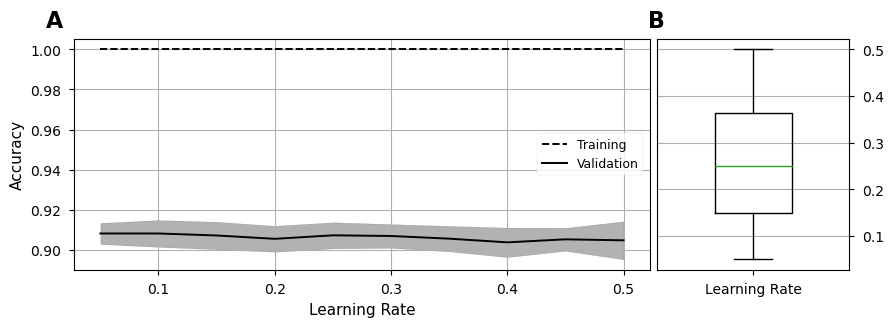

In [54]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3),
                        gridspec_kw={"width_ratios": (3, 1)})

ax1 = axs[0]
plot_validation_curve(cv_df, ax=ax1)
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend()

ax2 = axs[1]
param_df.boxplot(ax=ax2, grid=False, widths=0.4, boxprops={"color":"k"}, whiskerprops={"color":"k"})
ax2.grid(axis="y")
ax2.set_xticklabels(["Learning Rate"])
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

for i, ax in enumerate(axs):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.02)
fig.align_labels()

fig.savefig(img_path / "gbdt_validation.png", format="png", dpi=300, bbox_inches="tight")

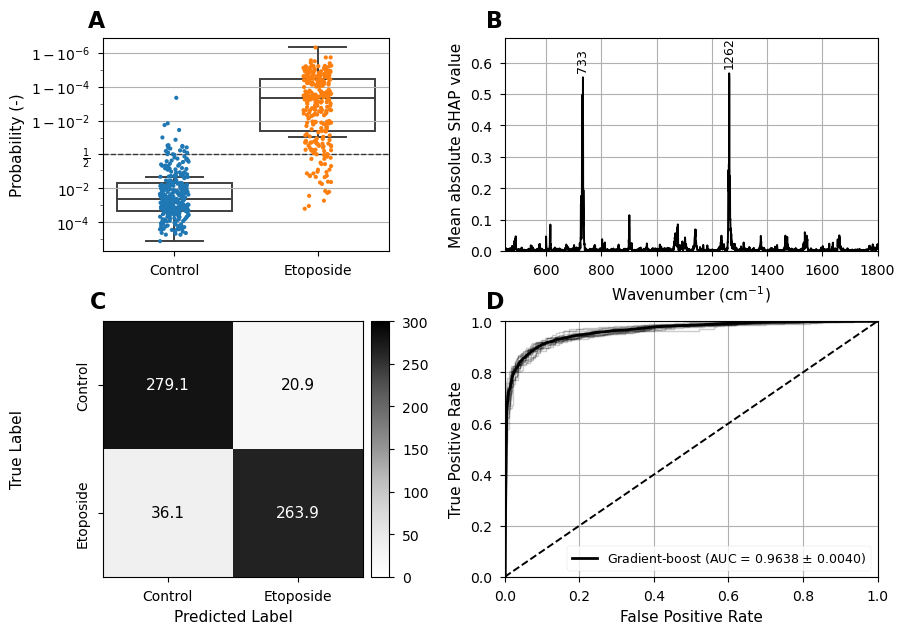

In [55]:
fig, axs = plt.subplots(nrows=2, ncols=2,
                        gridspec_kw={"width_ratios": (1, 1.3), 
                                     "height_ratios": (1, 1.2)})

ax1 = axs[0,0]
plot_confidence_scores(proba_df, y_key[y], y_key, markersize=3, ax=ax1)
ax1.axhline(0.5, color="k", linestyle="--", linewidth=1, alpha=0.7)
ax1.set_yscale("logit")
ax1.set_ylabel("Probability (-)")
ax1.grid(axis="y")

ax2 = axs[0,1]
plot_coefs(shap_val_df, ax=ax2, col=False, annotate=True, annot_kw={"min_height": 0.25, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})

ax2.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax2.set_ylabel("Mean absolute SHAP value")
ax2.margins(x=0, y=0.2)
ax2.set_ylim(0, None)
ax2.grid()

ax3 = axs[1,0]
plot_confusion_matrix(pred_df, y, labels=y_key, ax=ax3, cmap="Greys", colorbar=True, aspect="auto")


ax4 = axs[1,1]
rocs[name], aucs[name] = plot_roc_curve(proba_df, y, name, ax=ax4)
ax4.set_xlabel(f"False Positive Rate")
ax4.set_ylabel(f"True Positive Rate")
ax4.legend(loc="lower right")
ax4.grid()

for i, ax in enumerate(axs.ravel()):
    ax.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=16, weight="bold")

fig.subplots_adjust(wspace=0.35, hspace=0.3)
fig.align_xlabels()
fig.align_ylabels(axs=[ax1, ax3])

fig.savefig(img_path / "gbdt_combined.png", format="png", dpi=300, bbox_inches="tight")

### Explainable AI - SHAP

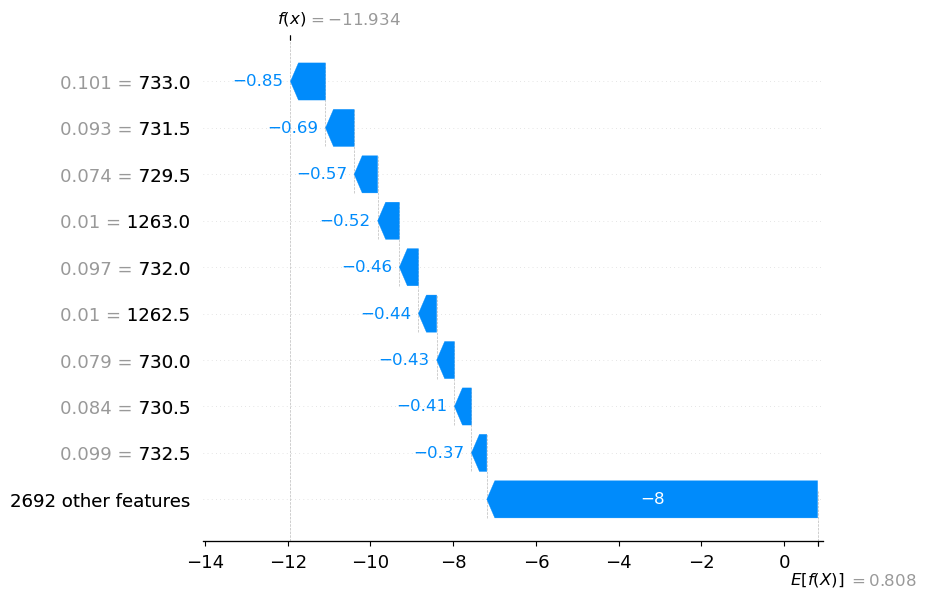

In [56]:
fig, ax = plt.subplots()
first_expl = explanation[0]
first_expl.feature_names = shap_features.astype(str)
shap.waterfall_plot(first_expl)

fig.savefig(img_path / "gbdt_shap_waterfall.png", format="png", dpi=300, bbox_inches="tight")

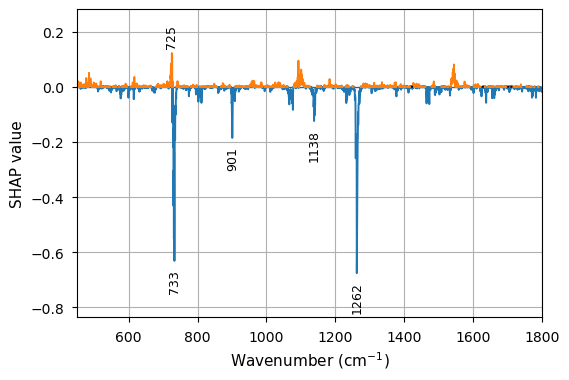

In [60]:
fig, ax = plt.subplots(figsize=(6,4))
plot_coefs(pd.Series(shap_vals[1,:], index=shap_features), ax=ax, annotate=True, annot_kw={"min_height": 0.1, 
                                                                    "min_dist": 50,
                                                                    "offset": 6,
                                                                    "fontsize": 9})
ax.set_xlabel("Wavenumber ($\mathregular{cm^{-1}}$)")
ax.set_ylabel("SHAP value")
ax.margins(x=0, y=0.2)
ax.grid()

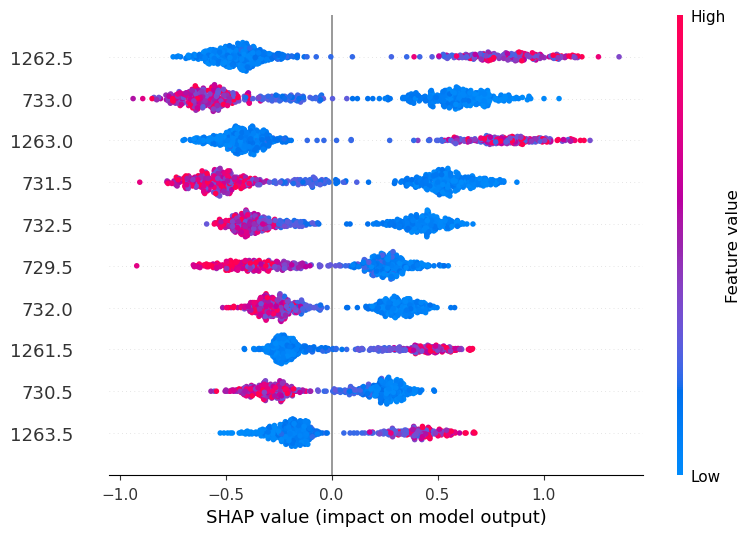

In [57]:
fig, ax = plt.subplots()
shap.summary_plot(explanation, feature_names=shap_features, max_display=10)

fig.savefig(img_path / "gbdt_shap.png", format="png", dpi=300, bbox_inches="tight")

## Comparison of Tree-based Models

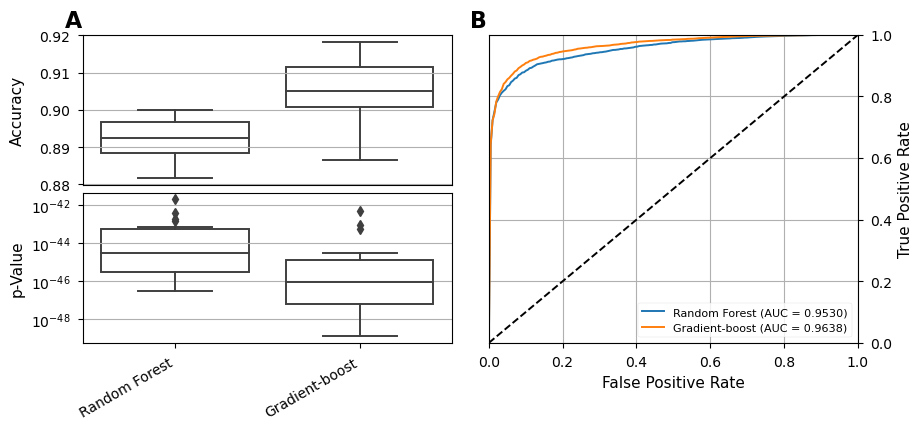

In [58]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="Tree|Forest|Gradient", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="Tree|Forest|Gradient", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="Tree|Forest|Gradient")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")

fig.align_ylabels()

fig.savefig(img_path / "tree_comparison.png", format="png", dpi=300, bbox_inches="tight")

## Overall Comparison

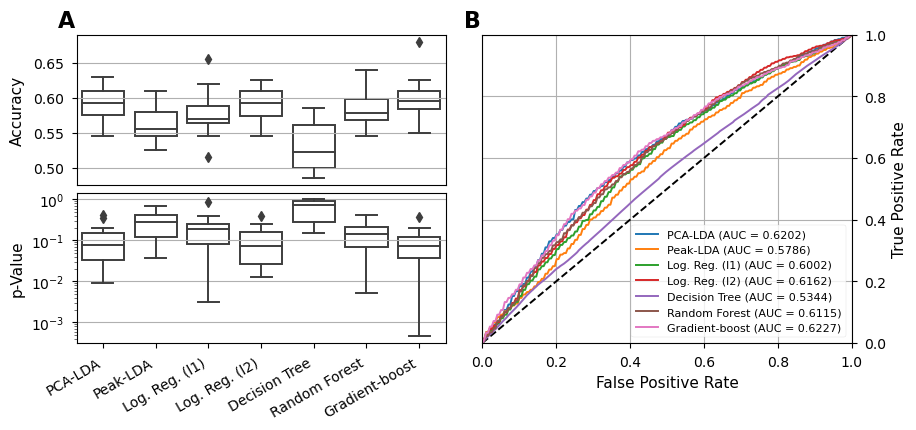

In [64]:
fig = plt.figure(figsize=(10, 4))

gs = gridspec.GridSpec(2, 2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(gs[0,0])
boxplot_comparison(accs, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient", ax=ax1)
ax1.grid(axis="y")
ax1.set_ylabel("Accuracy")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="x", length=0)

ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
boxplot_comparison(p_vals, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient", ax=ax2)
ax2.set_yscale("log")
ax2.grid(axis="y")
ax2.set_ylabel("p-Value")
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment="right")

ax3 = fig.add_subplot(gs[:,1])
plot_roc_comparison(rocs, aucs, ax=ax3, regex="PCA|Peak|Log. Reg|Tree|Forest|Gradient")
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.grid()
ax3.set_xlabel(f"False Positive Rate")
ax3.set_ylabel(f"True Positive Rate")
ax3.legend(loc="lower right", fontsize=8)

ax1.text(-0.05, 1.05, "A", transform=ax1.transAxes, size=16, weight="bold")
ax3.text(-0.05, 1.025, "B", transform=ax3.transAxes, size=16, weight="bold")

fig.align_ylabels()

fig.savefig(img_path / "all_comparison.png", format="png", dpi=300, bbox_inches="tight")